#  **ENCODER MODEL**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization,MaxPooling1D,GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import itertools
#import shutil
%matplotlib inline


**Conv 2d with batch normalization**

In [ ]:
def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
  x = Conv2D(numfilt,filtsz,strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
  x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
  if act:
    x = Activation('relu',name=name+'conv2d'+'act')(x)
  return x

 **Inception Resnet Block A**

**Scaling**
According to them, scaling down the residuals before adding them to the previous layer activation seemed to stabilize the training. To scale the residuals, scaling factors between 0.1 and 0.3 were picked.

In [ ]:
def incresA(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,256,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

 **Inception Resnet Block B**

In [ ]:

def incresB(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,896,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

 **Inception Resnet Block C**

In [ ]:

def incresC(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,192,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,224,[1,3],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,256,[3,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,1888,1,1,pad,False,name=name+'fin1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_saling')([x, filt_exp_1x1])
    return final_lay

**Encoder Model Whole**

In [ ]:
img_input = Input(shape=(299,299,3))

x = conv2d(img_input,32,3,2,'valid',True,name='conv1')
x = conv2d(x,64,3,1,'valid',True,name='conv2')
# x = conv2d(x,64,3,1,'valid',True,name='conv3')
# print(x.shape)
# print()

x_11 = MaxPooling2D(3,strides=2,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
x_12 = conv2d(x,96,3,2,'valid',True,name='stem_br_12')

x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
x_21 = conv2d(x_21,96,3,1,'valid',True,name='stem_br_214')

x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
x_22 = conv2d(x_22,96,3,1,'valid',True,name='stem_br_222')

x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

x_31 = conv2d(x,192,3,2,'valid',True,name='stem_br_31')
x_32 = MaxPooling2D(3,strides=2,padding='valid',name='stem_br_32'+'_maxpool_2')(x)

x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])

x = conv2d(x,256,3,1,'same',True,name='stem_br_312')








#Inception-ResNet-A modules
x = incresA(x,0.15,name='incresA_1')
# print("resnet a1")
# print(x.shape)
x = incresA(x,0.15,name='incresA_2')
x = incresA(x,0.15,name='incresA_3')
x = incresA(x,0.15,name='incresA_4')
x = incresA(x,0.15,name='incresA_5')
# print("resnet a")
# print(x.shape)

#35 × 35 to 17 × 17 reduction module A.
x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)
# print(x_red_11.shape)
# print()
x_red_12 = conv2d(x,256,3,2,'valid',True,name='x_red1_c1')
# print(x_red_12.shape)
# print()

x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')
print(x_red_13.shape)
print()

x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])
print("rededuction A")
print(x.shape)

#Inception-ResNet-B modules
x = incresB(x,0.1,name='incresB_1')
x = incresB(x,0.1,name='incresB_2')
x = incresB(x,0.1,name='incresB_3')
x = incresB(x,0.1,name='incresB_4')
x = incresB(x,0.1,name='incresB_5')
x = incresB(x,0.1,name='incresB_6')
x = incresB(x,0.1,name='incresB_7')
x = incresB(x,0.1,name='incresB_8')
x = incresB(x,0.1,name='incresB_9')
x = incresB(x,0.1,name='incresB_10')
print("resnet b")
print(x.shape)

#17 × 17 to 8 × 8 reduction module.
x_red_21 = MaxPooling2D(pool_size=2,strides=2,padding='valid',name='red_maxpool_2')(x)
print(x_red_21.shape)
print()

x_red_22 = conv2d(x,256,1,1,'same',True,name='x_red2_c11')
x_red_22 = conv2d(x_red_22,384,3,2,'valid',True,name='x_red2_c12')
print(x_red_22.shape)
print()
x_red_23 = conv2d(x,256,1,1,'same',True,name='x_red2_c21')
x_red_23 = conv2d(x_red_23,288,3,2,'valid',True,name='x_red2_c22')
print(x_red_23.shape)
print()
x_red_24 = conv2d(x,256,1,1,'same',True,name='x_red2_c31')
x_red_24 = conv2d(x_red_24,288,3,1,'same',True,name='x_red2_c32')
x_red_24 = conv2d(x_red_24,320,3,2,'valid',True,name='x_red2_c33')
print(x_red_24.shape)
print()
x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])
print("red 2")
print(x.shape)

#Inception-ResNet-C modules
x = incresC(x,0.2,name='incresC_1')
x = incresC(x,0.2,name='incresC_2')
x = incresC(x,0.2,name='incresC_3')
x = incresC(x,0.2,name='incresC_4')
x = incresC(x,0.2,name='incresC_5')
print("resnet c")
print(x.shape)



# #TOP
x = GlobalMaxPooling2D()(x)
print("Global AVg Pool")
print(x.shape)
# print()
# x = Dropout(0.6)(x)
# x = Dense(1000, activation='softmax')(x)
# print(x.shape)

(None, 17, 17, 384)

rededuction A
(None, 17, 17, 896)
resnet b
(None, 17, 17, 896)
(None, 8, 8, 896)

(None, 8, 8, 384)

(None, 8, 8, 288)

(None, 8, 8, 320)

red 2
(None, 8, 8, 1888)
resnet c
(None, 8, 8, 1888)
Global AVg Pool
(None, 1888)


In [ ]:
model = Model(img_input,x,name='inception_resnet_v2')

In [ ]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1conv2d (Conv2D)           (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1conv2dbn (BatchNormalizat  (None, 149, 149, 32  96         ['conv1conv2d[0][0]']            
 ion)                           )                                               

#  **Whole Model**

In [ ]:
!pip install tensorflow==2.3.0      # CPU
!pip install tensorflow-gpu==2.3.0 # GPU

     |████████████████████████████████| 320.4 MB 50 kB/s 
     |████████████████████████████████| 2.9 MB 31.1 MB/s 
     |████████████████████████████████| 459 kB 49.4 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
 

     |████████████████████████████████| 320.4 MB 51 kB/s 


In [ ]:
!pip install numpy==1.19.5

     |████████████████████████████████| 14.8 MB 5.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.
tensorflow-gpu 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install h5py==2.10.0

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
#from tensorflow.keras.models import Model
from tensorflow.python.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import itertools
#import shutil
%matplotlib inline

In [ ]:
from sklearn.model_selection import KFold, GroupKFold

# 2.5% valid = 3975 captions = 795 images
kf = GroupKFold(n_splits=40).split(X=full_img_name_list, groups=range(0,158915))

for ind, (tr, val) in enumerate(kf):
    img_name_train = np.array(full_img_name_list)[tr] # np.array make indexing possible
    img_name_val = np.array(full_img_name_list)[val]
  
    # print(tr)
    # print(val)
    cap_train =  np.array(all_captions_list)[tr]
    # print(cap_train)
    # print(len(img_name_train))
    # print(len(cap_train))
    # print(img_name_train[:5])
    # print(cap_train[:5])
    cap_val =  np.array(all_captions_list)[val] 

# np.save('/content/Copy of img_name_val.npy',img_name_val)
# np.save('/content/Copy of img_name_train.npy',img_name_train)
# np.save('/content/Copy of cap_val.npy',cap_val)
# np.save('/content/Copy of cap_train.npy',cap_train)


In [ ]:
def get_all_image_ids(dataset='train'):
  if dataset=='train':
    train_name_lst=np.load('/content/drive/MyDrive/img_name_train.npy')
    train_name_lst=list(train_name_lst)
    train_name_lst=list(map(lambda x:x[43:],train_name_lst))
    train_name_lst=list(map(lambda x:x.split('.')[0],train_name_lst))
    #print(train_name_lst[:10])
   # print(len(train_name_lst))
    return train_name_lst

  elif dataset=='val':
    val_name_lst=np.load('/content/drive/MyDrive/img_name_val.npy')
    val_name_lst=list(val_name_lst)
    val_name_lst=list(map(lambda x:x[43:],val_name_lst))
    val_name_lst=list(map(lambda x:x.split('.')[0],val_name_lst))
   # print(val_name_lst[:10])
   # print(len(val_name_lst))
    return val_name_lst
    

# get_all_image_ids('val')
#a=get_all_image_ids('train')

In [ ]:
def get_all_full_image_names(dataset='train'):
  if dataset=='train':
    train_name_lst=np.load('/content/drive/MyDrive/img_name_train.npy')
    train_name_lst=list(train_name_lst)
    #print(train_name_lst[:10])
   # print(len(train_name_lst))
    return train_name_lst

  elif dataset=='val':
    val_name_lst=np.load('/content/drive/MyDrive/img_name_val.npy')
    val_name_lst=list(val_name_lst)
    #  print(val_name_lst[:10])
   # print(len(val_name_lst))
    return val_name_lst
    

# a=get_all_full_image_names('val')
# a=get_all_full_image_names('train')

In [ ]:
def get_all_captions(dataset='train'):
  if dataset=='train':
    train_name_lst=np.load('/content/drive/MyDrive/cap_train.npy')
    train_name_lst=list(train_name_lst)
    captions = ['<start>%s<end>' % caption for caption in train_name_lst]
    return captions
    #print(train_name_lst[:10])
   # print(len(train_name_lst))
    # return train_name_lst

  elif dataset=='val':
    val_name_lst=np.load('/content/drive/MyDrive/cap_val.npy')
    val_name_lst=list(val_name_lst)
    captions = ['<start>%s<end>' % caption for caption in val_name_lst]
    return captions

   # print(val_name_lst[:10])
   # print(len(val_name_lst))
    # return val_name_lst
    

#a=get_all_captions('val')
# get_all_captions('train')

**Imports**

In [ ]:

import json
import os

import numpy as np
import tensorflow as tf

from absl import logging
from tensorflow.data import Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

**Config**

In [ ]:
class Config(object):


    def __init__(self):
        # general
        self.log_dir = './log/'  # 'log' or None

        # about the model architecture
        self.cnn = 'inception_resnet_v2' 
        self.rnn = 'lstm'       
        self.embedding_dim = 256
        self.rnn_units = 512
        self.num_features = 256
        self.use_attention = True
        
        # about the weight initialization and regularization
        self.weight_initialization = 'glorot_uniform' # 'glorot', 'xavier', etc.
        self.dropout = 0.5

        # about the optimization
        self.num_epochs = 1
        self.batch_size = 64
        self.optimizer = 'Nadam'  # 'Adam', 'RMSProp', 'Momentum' or 'SGD'
        # self.loss = 'sparse_categorical_crossentropy'

        # about the dataset
        self.dataset_name = 'flickr30k'

        
        self.buffer_size = 1000
        self.drop_remainder = True
        self.limit_length = True
        self.max_length = 25

        # about the saver (checkpoint manager)
        self.max_checkpoints = 10 # max number of checkpoints to keep 
        self.checkpoints_frequency = 1 # number of epochs before saving checkpoint
        self.checkpoints_dir = '/content/drive/MyDrive/clg training material/checkpoints/'
        self.summary_dir = '/content/drive/MyDrive/summary/' 

        # about the vocabulary 
        self.vocabulary_file = '/content/vocabulary.pickle'
        self.vocabulary_size = 9000

        # about image features
        self.extract_image_features = True
        self.image_features_batchsize = 16
        self.image_features_dir = '/content/drive/MyDrive/feature_maps_cache/'  #'./feature_maps_cache/'

        # about the training
        self.resume_from_checkpoint = True
        self.num_train_examples =  None
        self.pred_lst=[]
        #self.train_image_dir = './data/coco/train2014/'
        #self.train_captions_file = './data/coco/annotations/captions_train2014.json'

        # about the evaluation
        self.beam_width = 3
        self.use_beam_search = True
        self.normalize_by_length = True
        # self.eval_image_dir = './data/coco/val2014/'
        # self.eval_captions_file = './data/coco/annotations/captions_val2014.json'
        self.eval_result_dir = '/content/drive/MyDrive/results/eval/images/'
        self.eval_result_file = '/content/drive/MyDrive/results/eval/eval_results.json'
        self.save_eval_result_as_image = False

        # about the inference
        self.test_image_dir = '/content/drive/MyDrive/results/test/images/'
        self.test_result_dir = '/content/drive/MyDrive/results/test/'
        self.test_result_file = '/content/drive/MyDrive/results/test_results.csv'



**Dataset**

In [ ]:
class DataSet(object):

    def __init__(self,
                name,
                image_ids,
                image_feature_files,
                captions,
                batch_size,
                shuffle=False,
                buffer_size=1000,
                drop_remainder=False):
        self.image_ids = np.array(image_ids)
        self.image_features_files = np.array(image_feature_files)
        self.captions = captions
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.buffer_size = buffer_size
        self.drop_remainder = drop_remainder
        self.setup()

    def setup(self):

        self.num_instances = len(self.image_features_files)
        self.num_batches = int(np.ceil(self.num_instances * 1.0 / self.batch_size))
        # self.num_batches = self.num_instances // self.batch_size

        dataset = Dataset.from_tensor_slices((self.image_features_files, self.captions))
        # using map to load the numpy files in parallel
        dataset = dataset.map(
            lambda item1, item2: tf.numpy_function(
                map_image_features_to_caption, [item1, item2], [tf.float32, tf.int32]
                ),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
        # shuffling and batching the train dataset
        if self.shuffle:
            dataset = dataset.shuffle(self.buffer_size).batch(self.batch_size, drop_remainder=self.drop_remainder)
        else:
            dataset = dataset.batch(self.batch_size, drop_remainder=self.drop_remainder)

        self.dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

def map_image_features_to_caption(npy_file, caption):


    image_features = np.load(npy_file.decode('utf-8'))
    return image_features, caption

def prepare_train_data(config):


    print("Preparing training data for %s...", config.dataset_name)

    # obtaining the image ids, image files and text captions
    image_ids = get_all_image_ids('train')
    dataset_size = len(image_ids)
    print("Total number of instances in the training set: %d", dataset_size)
    # if config.filter_by_caption_length:
    #     coco.filter_by_cap_len(config.max_caption_length)
    #image_ids = coco.get_all_image_ids()

    # if len(image_ids) < dataset_size:
    #     print("Using just %d images for the training phase", len(image_ids))
    # else:
    #     print("Using full validation set")

    #image_filenames = coco.get_image_filenames(image_ids)
    print("Using full validation set")
    print(image_ids[:10])
    image_features_files = [os.path.join(config.image_features_dir, config.cnn, filename +'.jpg.npy') \
                            for filename in image_ids]
    text_captions = get_all_captions('train')

    vocabulary = load_or_build_vocabulary(config, text_captions)

    captions = vocabulary.process_sentences(text_captions)

    dataset = DataSet(
        '%s_%s'.format(config.dataset_name, 'Training'),
        image_ids,
        image_features_files,
        captions,
        config.batch_size,
        shuffle= True,
        buffer_size= config.buffer_size,
        drop_remainder= config.drop_remainder
    )

    return dataset, vocabulary


def prepare_eval_data(config):

    
    print("Preparing validation data for %s...", config.dataset_name)

    # obtaining the image ids, image files and text captions
    #coco = COCO(config.eval_captions_file)
    #image_ids = coco.get_unique_image_ids()
    #dataset_size = len(image_ids)
    image_ids = get_all_image_ids('val')
    dataset_size = len(image_ids)
    print("Total number of instances in the validation set: %d", dataset_size)
    # if config.filter_by_caption_length:
    #     coco.filter_by_cap_len(config.max_caption_length)
    #image_ids = coco.get_unique_image_ids()

    # 
#if len(image_ids) < dataset_size:
    #     print("Using just %d images for the evaluation phase", len(image_ids))
    # else:
    #     print("Using full validation set")
    print("Using full validation set")
    #image_filenames = coco.get_image_filenames(image_ids)
    image_features_files = [os.path.join(config.image_features_dir, config.cnn, filename +'.jpg.npy') \
                        for filename in image_ids]
    text_captions = get_all_captions('val')

    vocabulary = load_or_build_vocabulary(config)

    captions = vocabulary.process_sentences(text_captions)

    dataset = DataSet(
        '%s_%s'.format(config.dataset_name, 'Validation'),
        image_ids,
        image_features_files,
        captions,
        config.batch_size,
        shuffle= False,
        buffer_size= config.buffer_size,
        drop_remainder= False
    )

    return dataset, vocabulary



**Evaluation**

In [ ]:

class Hypothesis(object):

  def __init__(self, tokens, log_prob, state):

    self.tokens = tokens
    self.log_prob = log_prob
    self.state = state

  def extend(self, token, log_prob, new_state):
  
    return Hypothesis(self.tokens + [token], 
                      self.log_prob + log_prob,
                      new_state)

  @property
  def latest_token(self):
    return self.tokens[-1]

  def __str__(self):
    return ('Hypothesis(log prob = %.4f, tokens = %s)' %
            (self.log_prob, self.tokens))


def best_hypothesis(hyps, normalize_by_length):

    # This length normalization is only effective for the final results.
    if normalize_by_length:
      return sorted(hyps, key=lambda h: h.log_prob/len(h.tokens), reverse=True)
    else:
      return sorted(hyps, key=lambda h: h.log_prob, reverse=True)
def generate_captions_with_greedy_search(model, img_features, sequence_length, vocabulary):
  
    # get model components (encoder, decoder and tokenizer)
    encoder = model.encoder
    decoder = model.decoder
    # get batch size and caption length
    batch_size=img_features.shape[0]
    # Initializing the hidden state for each batch, since captions are not related from image to image
    hidden = decoder.reset_state(batch_size=batch_size)
    # Expands input to decoder, generates a batch of sequences of length=1, with 
    # word index corresponding to '<start>', that is, shape = (64,1)
    dec_input = tf.expand_dims([vocabulary.start] * batch_size, 1)
    # Passes visual features through encoder
    features = encoder(img_features, training=False)
    predicted_sequences = []
    for t in range(sequence_length):
        # Passing input, features and hidden state through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden, training=False)
        # predictions shape = (batch_size, vocabulary_size)
        predicted_word_idxs = tf.argmax(predictions, axis=1)
        predicted_sequences.append(predicted_word_idxs)
        dec_input = tf.expand_dims(predicted_word_idxs, 1)
    predicted_sequences = tf.stack(predicted_sequences, axis=1)
    return predicted_sequences.numpy()
def generate_captions_with_beam_search(model, img_features, sequence_length, vocabulary, beam_width=3, normalize_by_length=True):
  

    # get model components (encoder, decoder and tokenizer)
    encoder = model.encoder
    decoder = model.decoder
    tokenizer = model.tokenizer
    start_token = vocabulary.start
    end_token = vocabulary.end

    # get batch size 
    batch_size=img_features.shape[0]
    # Initialization of hidden states 
    batch_hidden = decoder.reset_state(batch_size=batch_size)
    # Passes visual features through encoder
    batch_features = encoder(img_features)
    predicted_sequences = []
    for idx in tqdm(range(batch_size), desc='beam'):
        # Initialize the hypothesis: start_token will be the initial input
        # Replicate the initial states K times for the first step.
        hyps = [Hypothesis([tf.convert_to_tensor(start_token)], 0.0, batch_hidden[idx])] * beam_width
        features = tf.stack([batch_features[idx]] * beam_width)
        # Run beam search
        results = []
        steps = 0
        while steps < sequence_length and len(results) < beam_width:
            latest_tokens = [h.latest_token for h in hyps]
            states = [h.state for h in hyps]         

            # Last tokens become next decoder input, a tensor with shape (beam_size, 1)
            dec_input = tf.expand_dims(latest_tokens,1)    
            # Convert array of hidden states to tensor with shape (beam_size, rnn_units)
            hidden = tf.convert_to_tensor(states)
            # Pass input, image features and hidden state to get new predictions (output) and hidden state.
            # Predictions is tensor with shape (beam_size, vocabulary_size) 
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            topk_log_probs, topk_ids = tf.nn.top_k(predictions,k=beam_width*2)
            
            # topk_ids = topk_ids.numpy()

            # Extend each hypothesis.
            all_hyps = []
            # The first step takes the best K results from first hyps. Following
            # steps take the best K results from K*K hyps.
            num_beam_source = 1 if steps == 0 else len(hyps)
            for i in xrange(num_beam_source):
                hyp, hid = hyps[i], hidden[i]
                for j in xrange(beam_width*2):
                    all_hyps.append(hyp.extend(topk_ids[i, j], topk_log_probs[i, j], hid))

            # Filter and collect any hypotheses that have the end token.
            hyps = []
            for h in best_hypothesis(all_hyps, normalize_by_length):
                if h.latest_token == end_token:
                    # Pull the hypothesis off the beam if the end token is reached.
                    results.append(h)
                else:
                    # Otherwise continue to extend the hypothesis.
                    hyps.append(h)
                if len(hyps) == beam_width or len(results) == beam_width:
                    break
            steps += 1

        if steps == sequence_length:
            results.extend(hyps)

        best_hyp = best_hypothesis(results, normalize_by_length)[0]
        predicted_sequences.append([t.numpy() for t in best_hyp.tokens])
        # predicted_sequences.append(best_hyp.tokens)

    return predicted_sequences

def eval(model, eval_dataset, vocabulary, config):
 

    # Get the evaluation dataset and parameters.
    dataset = eval_dataset.dataset
    num_examples = eval_dataset.num_instances
    batch_size = eval_dataset.batch_size
    num_batches = eval_dataset.num_batches
    print('dataset',dataset)
    print('num_exam',num_examples)
    print('batchsize',batch_size)
    print('numbatches',num_batches)
    # Need an optimizer to recreate model from checkpoint
    # Although it is not being used for evaluation
    optimizer = tf.optimizers.get(config.optimizer)
    
    logging.info("Evaluating %d examples", num_examples)
    logging.info("Divided into %d batches of size %d", num_batches, batch_size)

    # load model from last checkpoint
    ckpt_manager, ckpt = get_checkpoint_manager(model, optimizer, config.checkpoints_dir, config.max_checkpoints)
    status = ckpt.restore(ckpt_manager.latest_checkpoint)
    if ckpt_manager.latest_checkpoint:
        # assert_consumed() raises an error because of delayed restoration 
        # See https://www.tensorflow.org/alpha/guide/checkpoints#delayed_restorations
        # status.assert_consumed() 
        status.assert_existing_objects_matched()
    epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

    results = []
    i = 0
    # Iterate over the batches of the dataset.
    for (batch, (img_features, target)) in tqdm(enumerate(dataset), desc='batch', total=num_batches):      
        # Obtain the actual size of this batch,  since it may differ 
        # from predefined batchsize when running the last batch of an epoch
        batch_size=target.shape[0]
        sequence_length=target.shape[1]
        # if config.use_beam_search:
        #     predicted_captions = generate_captions_with_beam_search(
        #             model, img_features, sequence_length, vocabulary,
        #             config.beam_width, config.normalize_by_length)
        if config.use_beam_search:
            predicted_captions = generate_captions_with_beam_search(
                    model, img_features, sequence_length, vocabulary,
                    config.beam_width, config.normalize_by_length)
        else:
            predicted_captions = generate_captions_with_greedy_search(
                    model, img_features, sequence_length, vocabulary)
        for k, sequence in enumerate(predicted_captions):
            predicted_caption = vocabulary.seq2text(sequence)
            results.append({'image_id': eval_dataset.image_ids[i].item(),
                            'caption': predicted_caption
                            # 'ground_truth': vocabulary.seq2text(eval_dataset.captions[i])
                            })
            i += 1

    # Save results to file
    eval_dir = os.path.abspath(config.eval_result_dir)
    if not os.path.exists(eval_dir):
        os.mkdir(eval_dir)
    with open(config.eval_result_file, 'w') as handle:
        json.dump(results, handle)

    return results

def evaluate(config):
    

    eval_dataset, vocabulary = prepare_eval_data(config)
    model = build_model(config, vocabulary)
    # start = time.time()
    results = eval(model, eval_dataset, vocabulary, config)
    print(results)
    original = get_all_captions('val')
    print(original)
    # logging.info('Total caption generation time: %d seconds', time.time() - start)

    # Evaluate these captions
    start = time.time()
    # coco_eval_result = coco_eval.loadRes(config.eval_result_file)
    # scorer = COCOEvalCap(coco_eval, coco_eval_result)
    #scorer.evalute()
    # eval(model, eval_dataset, config, vocabulary)
    logging.info("Evaluation complete.")
    logging.info('Total evaluation time: %d seconds', time.time() - start)

**Images**

In [ ]:
IMAGE_SIZE = {'inception_resnet_v2': (299,299)}

def preprocess_images(config):
  

    print("Preprocessing images (extracting image features)...")

    cnn = config.cnn

    batchsize = config.image_features_batchsize
    
    # If needed create folder for saving image features
    features_dir = config.image_features_dir
    if not os.path.exists(features_dir):
        os.makedirs(features_dir)

    # Create feature extraction layer
     encoder= get_image_encoder(cnn)


    #train ki image ids chaiye and eval ki 

    # Obtain image files for training dataset
    # coco_train = COCO(config.train_captions_file)
    #train_image_ids = coco_train.get_unique_image_ids()\
    train_image_ids=get_all_image_ids('train')
    # train_image_filenames = coco_train.get_image_filenames(train_image_ids)
    
    # Obtain image files for evaluation dataset
    # coco_eval = COCO(config.eval_captions_file)
    # eval_image_ids = coco_eval.get_unique_image_ids()
    eval_image_ids=get_all_image_ids('val')
    # eval_image_filenames = coco_eval.get_image_filenames(eval_image_ids)
    

    #full image filenames
    # image_files = coco_train.get_image_files(config.train_image_dir, train_image_ids) \
    #             + coco_eval.get_image_files(config.eval_image_dir, eval_image_ids)

    image_files=get_all_full_image_names('train')+get_all_full_image_names('val')


    # Create a dataset with images ready to be fed into the encoder (cnn for extracting image features) in batches 
    image_dataset = Dataset.from_tensor_slices(sorted(image_files))
    image_dataset = image_dataset.map(image_preprocessing_function(cnn), num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batchsize)

    features_dir = os.path.join(features_dir, cnn)
    if not os.path.exists(features_dir):
        os.makedirs(features_dir)

    for images, image_filenames in tqdm(image_dataset, desc='image_batch'):
        # obtain batch of image features
        image_features = encoder(images)
        image_features = tf.reshape(image_features, (image_features.shape[0], -1, image_features.shape[3]))
        # Save image features as '.npy' files
        for img_features, img_filename in zip(image_features, image_filenames):
            features_path = os.path.join(
                    config.image_features_dir, cnn, 
                    os.path.basename(img_filename.numpy().decode('utf-8'))
                    )
            np.save(features_path, img_features.numpy())

def image_preprocessing_function(cnn):
  
    image_size = IMAGE_SIZE[cnn]
    from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

    def load_and_preprocess_image(image_file):
        image = tf.io.read_file(image_file)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = preprocess_input(image)
        return image, image_file
        
    return load_and_preprocess_image

def get_image_encoder(cnn):

    #load model
    image_model = tf.keras.models.load_model("/content/drive/MyDrive/encoder_model.h5")

    #image_model = PTModel(include_top=False, weights='imagenet')
    new_input = image_model.input
    hidden_layer = image_model.layers[-2].output
    pretrained_image_model = Model(new_input, hidden_layer)
    return pretrained_image_model


def plot_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    plt.imshow(image)
    plt.show()

**Models**

In [ ]:
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Embedding, Dropout

class ImageCaptionModel(object):
 
    def __init__(self, num_features, embedding_dim, rnn, rnn_units, weight_initialization, dropout, vocabulary, use_attention = True):
   
        self.encoder = CNN_Encoder(num_features, dropout)
        self.decoder = RNN_Decoder(embedding_dim, 
                                    rnn, rnn_units,
                                    vocabulary.size,
                                    weight_initialization,
                                    dropout,
                                    use_attention)
        self.tokenizer = vocabulary.tokenizer

class CNN_Encoder(tf.keras.Model):
   

    # We have already extracted the features and saved them as npy arrays
    # This encoder only has to pass those features through a fully connected layer
    def __init__(self, num_features, dropout):
        super(CNN_Encoder, self).__init__()
        self.do = Dropout(dropout)
        self.fc = Dense(num_features)

    def call(self, x, training=True):
        # shape of x == (batch_size, patches, channels)
        if training:
            x = self.do(x)
        x = self.fc(x)
        # shape of x after fc == (batch_size, patches, num_features)
        x = tf.nn.relu(x)
        return x

class BahdanauAttention(tf.keras.Model):


    def __init__(self, units, dropout):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.do = Dropout(dropout)
        self.V = Dense(1)

    def call(self, features, hidden, training=True):
        # features(CNN_encoder output) shape == (batch_size, patches, num_features)
        # patches = number of image patches in last conv layer, eg. inception is 8x8 = 64

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, patches, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        if training:
            score = self.do(score)
        # attention_weights shape == (batch_size, patches, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape == (batch_size, patches, num_features)
        context_vector = attention_weights * features
        # context_vector shape after reduce_sum == (batch_size, num_features)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):


    def __init__(self, embedding_dim, rnn, units, vocab_size, weight_initialization, dropout, use_attention):
        super(RNN_Decoder, self).__init__()
        if rnn=='gru':
            from tensorflow.keras.layers import GRU as RNNLayer
        else:
            from tensorflow.keras.layers import LSTM as RNNLayer
        
        self.rnn_type = rnn
        self.units = units
        self.use_attention = use_attention

        self.embedding = Embedding(vocab_size, embedding_dim)
        self.rnn = RNNLayer(units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer=weight_initialization)
        self.fc1 = Dense(units)
        self.do = Dropout(dropout)
        self.fc2 = Dense(vocab_size)
        self.attention = BahdanauAttention(units, dropout) if use_attention else None

    def call(self, x, features, hidden, training=True):

        # shape of context_vector == (batch_size, num_features)
        # TODO Check: according to some tutorials context vector shape = (batch_size, hidden_size)
        # but I'm getting (batch_size, num_features)
        # shape of attention = (batch_size, patches, 1)
        if self.use_attention:
            context_vector, attention_weights = self.attention(features, hidden, training)
        else:
            context_vector = tf.reduce_sum(features, axis=1)
            attention_weights = None

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, num_features + embedding)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the RNN
        if self.rnn_type == 'gru':
            output, state = self.rnn(x)
        else: # self.rnn_type =='lstm'
            output, state, _ = self.rnn(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        if training:
            x = self.do(x)
        
        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


def build_model(config, vocabulary):

    model = ImageCaptionModel(
                config.num_features,
                config.embedding_dim,
                config.rnn,
                config.rnn_units,
                config.weight_initialization,
                config.dropout,
                vocabulary,
                use_attention= config.use_attention)
    return model
    

**Text**

In [ ]:
import json
import os
import pickle

import numpy as np
import tensorflow as tf

from absl import logging
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

class Vocabulary(object):


    def __init__(self, vocabulary_size, sequence_length=None, save_file=None):

        self.size = vocabulary_size
        self.sequence_length = sequence_length
        if save_file is not None:
            self.load(save_file)

    def build(self, sentences):

        print("Tokenizer")
        # choosing the top k words from the vocabulary
        self.tokenizer = Tokenizer(
                                num_words=self.size,
                                oov_token="<unk>",
                                filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
        print("Tokenizer 2")
        self.tokenizer.fit_on_texts(sentences)
        # adds a padding token
        self.tokenizer.word_index['<pad>'] = 0
        self.tokenizer.index_word[0] = '<pad>'
        self.setup()


    def setup(self):
        num_words = len(self.tokenizer.word_index) + 1
        if self.size > num_words:
            self.size = num_words
        self.start = self.tokenizer.word_index['<start>']
        self.end = self.tokenizer.word_index['<end>']
        self.pad = self.tokenizer.word_index['<pad>']

    def seq2text(self, sequence):

        # sentence = ' '.join([self.tokenizer.index_word[i] for i in sequence if i not in [self.pad,self.end]])
        sentence = ''
        for idx in sequence:
            if idx in [self.pad, self.end]:
                break
            else:
                sentence += ' ' + self.tokenizer.index_word[idx]
        return sentence.lstrip()

    def process_sentences(self, sentences):


        # Tokenize sentences (convert them to sequences of indexes)
        sequences = self.tokenizer.texts_to_sequences(sentences)
        max_length = max_sequence_length(sequences)
        print("Processed %d sentences. Max length = %d", len(sequences), max_length)
        if self.sequence_length is None:
            self.sequence_length = max_length
        else:
            print("But it is set to : %d", self.sequence_length)
        # Pad sequences to met the max length.
        # If maxlen parameter is not provided, it is computed automatically
        sequences = pad_sequences(sequences, maxlen=self.sequence_length, padding='post')
        return sequences

    def save(self, save_file):
        """ Save the vocabulary to a file.
        """
        with open(save_file, 'wb') as handle:
            pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def load(self, save_file):
        """ Load the vocabulary from a file. 
        
        """
        with open(save_file, 'rb') as handle:
            self.tokenizer = pickle.load(handle)
        self.setup()


def load_or_build_vocabulary(config, sentences=None):
    vocabulary = Vocabulary(config.vocabulary_size, sequence_length=config.max_length if config.limit_length else None)
    if not os.path.exists(config.vocabulary_file):
        if sentences is None:
          # coco = COCO(config.train_captions_file)
            # if config.filter_by_caption_length:
            #     coco.filter_by_cap_len(config.max_caption_length)
            sentences = get_all_captions('train')
            print(sentences[:10])
        print("Building the vocabulary...")
        vocabulary.build(sentences)
        vocabulary.save(config.vocabulary_file)
        print("Vocabulary saved to %s." % config.vocabulary_file)
    else:
        print("Loading vocabulary from %s.", config.vocabulary_file)
        vocabulary.load(config.vocabulary_file)
    print("Num words: %d", len(vocabulary.tokenizer.word_index) + 1)
    print("Vocabulary size = %d" %(vocabulary.size))
    return vocabulary

def max_sequence_length(sequences):
    return max(len(seq) for seq in sequences)


**Training**

In [ ]:
import time

import matplotlib.pyplot as plt
import tensorflow as tf

from absl import logging
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.train import Checkpoint, CheckpointManager
from tqdm import tqdm

def compute_loss(labels, predictions, loss_function):
  
    mask = tf.math.logical_not(tf.math.equal(labels, 0))
    loss_ = loss_function(labels, predictions)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def get_checkpoint_manager(model, optimizer, checkpoints_dir, max_checkpoints=None):
   
    
    ckpt = Checkpoint(encoder = model.encoder,
                      decoder = model.decoder,
                      optimizer = optimizer)
    ckpt_manager = CheckpointManager(ckpt, checkpoints_dir, max_to_keep=max_checkpoints)

    return ckpt_manager, ckpt

@tf.function
def train_step(model, img_features, target, optimizer, loss_function):


    encoder = model.encoder
    decoder = model.decoder
    tokenizer = model.tokenizer
    loss = 0

    # Obtain the actual size of this batch, since it may differ from predefined batchsize
    # when running the last batch of an epoch
    batch_size=target.shape[0]
    sequence_length=target.shape[1]

    # Initializing the hidden state for each batch, since captions are not related from image to image
    hidden = decoder.reset_state(batch_size=batch_size)

    # Expands input to decoder
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)

    # Open a GradientTape to record the operations run during the forward pass, 
    # which enables autodifferentiation.
    
    with tf.GradientTape() as tape:
        # Passes visual features through encoder
        features = encoder(img_features)
        for i in range(1, sequence_length):
            # Passing input, features and hidden state through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            config.pred_lst.append(predictions)
            loss += compute_loss(target[:, i], predictions, loss_function)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(sequence_length))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


def fit(model, train_dataset, config):


    # Get the training dataset and various parameters.
    dataset = train_dataset.dataset
    num_examples = train_dataset.num_instances
    batch_size = train_dataset.batch_size
    num_batches = train_dataset.num_batches
    num_epochs = config.num_epochs
    # Instantiate an optimizer.
    optimizer = tf.keras.optimizers.get(config.optimizer)
    # Instantiate a loss function.
    loss_function = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    print("Training on %d examples for %d epochs", num_examples, num_epochs)
    print("Divided into %d batches of size %d", num_batches, batch_size)

    # Try to resume training from saved checkpoints
    resume_training = True
    if config.resume_from_checkpoint:
        ckpt_manager, ckpt = get_checkpoint_manager(model, optimizer, config.checkpoints_dir, config.max_checkpoints)
        status = ckpt.restore(ckpt_manager.latest_checkpoint)
        if ckpt_manager.latest_checkpoint:
            # assert_consumed() raises an error because of delayed restoration 
            # See https://www.tensorflow.org/alpha/guide/checkpoints#delayed_restorations
            # status.assert_consumed() 
            status.assert_existing_objects_matched()
            resume_training = True
    
    if resume_training:
        start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
        if start_epoch < config.num_epochs:
            print("Resuming training from epoch %d", start_epoch)
        # elif start_epoch==config.num_epochs:
        #     model.save('sainnyasahyogi.h5')

    else:
        start_epoch = 0
        print("Starting training from scratch")

    batch_losses = []

    # Iterate over epochs.
    for epoch in range(start_epoch, num_epochs):
        start = time.time()
        total_loss = 0
        print("*** Epoch %d ***" % epoch)
        # Iterate over the batches of the dataset.
        for (batch, (img_features, target)) in tqdm(enumerate(dataset), desc='batch', total=num_batches):
            batch_loss, t_loss = train_step(model, img_features, target, optimizer, loss_function)
            total_loss += t_loss

            # if batch % 100 == 0:
            #     caption_length = int(target.shape[1])
            #     print('Epoch %d Batch %d/%d Loss: %.4f',
            #         epoch + 1, batch, num_batches, batch_loss.numpy() / caption_length)
        # Storing the epoch end loss value to plot later
        batch_losses.append(total_loss / num_batches)

        print ('Epoch %d Loss %.6f', epoch + 1, total_loss / num_batches)
        print ('Time taken for 1 epoch: %d sec\n', time.time() - start)

        # Save checkpoint for the last epoch (with certain frequency)
        if epoch % config.checkpoints_frequency == 0:
            ckpt_manager.save()
    #model.save('sainnyasahyogi.h5')
    tf.keras.models.save_model('/content/drive/MyDrive/sainnyasahyogi.h5')
    #tf.keras.models.save_model(model,'sainnyasahyogi.h5')
    #model=save.model()
    return batch_losses
    

def plot_loss(losses):
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.show()

def train(config):
 
    print("cnn = %s", config.cnn)
    print("rnn = %s", config.rnn)
    print("embedding_dim = %s", config.embedding_dim)
    print("rnn_units = %s", config.rnn_units)
    print("num_features = %s", config.num_features)
    print("use_attention = %s", config.use_attention)
    print("weight_initialization = %s", config.weight_initialization)
    print("batch_size = %s", config.batch_size)
    print("optimizer = %s", config.optimizer)
    print("dropout = %s", config.dropout)

    train_dataset, vocabulary = prepare_train_data(config)
    model = build_model(config, vocabulary)
    start = time.time()
    losses = fit(model, train_dataset, config)
    if len(losses) > 0:
        print('Total training time: %d seconds', time.time() - start)
        print('Final loss after %d epochs = %.6f', config.num_epochs, losses[-1])
        print('Final loss after %d epochs = %.6f' % (config.num_epochs, losses[-1]))
        # plot_loss(losses)
    else:
        print("No training done, since number of epochs was reached")

**Main**

In [ ]:
config = Config()
if True:                 #FLAGS.phase == 'prepare':
        # build vocabulary
        load_or_build_vocabulary(config)
        # extracts and saves image features for later use
        if config.extract_image_features:
            preprocess_images(config)

elif FLAGS.phase == 'train': 
        # training phase: build and trains an image captioning model
        train(config)
        
elif FLAGS.phase == 'eval':
        # evaluation phase: evaluates a saved model on the validation data
        evaluate(config)

In [ ]:
config = Config()
if False:                 #FLAGS.phase == 'prepare':
        # build vocabulary
        load_or_build_vocabulary(config)
        # extracts and saves image features for later use
        if config.extract_image_features:
            preprocess_images(config)

elif False: #FLAGS.phase == 'train': 
        # training phase: build and trains an image captioning model
        train(config)
        
elif True:
        # evaluation phase: evaluates a saved model on the validation data
        evaluate(config)

In [ ]:
config = Config()
if False:                 #FLAGS.phase == 'prepare':
        # build vocabulary
        load_or_build_vocabulary(config)
        # extracts and saves image features for later use
        if config.extract_image_features:
            preprocess_images(config)

elif True: #FLAGS.phase == 'train': 
        # training phase: build and trains an image captioning model
        train(config)
        
elif FLAGS.phase == 'eval':
        # evaluation phase: evaluates a saved model on the validation data
        evaluate(config)

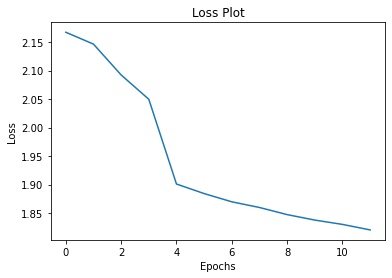

In [ ]:
batch_losses=[2.167348,2.146521,2.092371,2.0496785,1.900858,1.8840922, 1.8696295, 1.8596461, 1.847151, 1.8375528, 1.8299502, 1.8202814]
plot_loss(batch_losses)